In [1]:
import numpy as np
import pandas as pd
import tqdm

from scipy.stats import pearsonr, spearmanr, mannwhitneyu, ttest_ind, ttest_rel, wilcoxon, shapiro
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import mpl_scatter_density # needed for density scatter plots
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# COLORS:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (1e-20, "#440053"),
    (0.2, "#404388"),
    (0.4, "#2a788e"),
    (0.6, "#21a784"),
    (0.8, "#78d151"),
    (1, "#fde624"),
], N=256)
# "Viridis-like" colormap with white background
white_viridis_r = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (1e-20, "#fde624"),
    (0.4, "#78d151"),
    (0.6, "#21a784"),
    (0.7, "#2a788e"),
    (0.8, "#404388"),
    (1, "#440053"),
], N=256)
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

rng = np.random.RandomState(47)

In [2]:
def prc(y_true, y_scores):
    """
    Calculates precision and recall for different thresholds.

    Args:
        y_true (array-like): True binary labels.
        y_scores (array-like): Predicted probabilities or scores.

    Returns:
        precision (array): Precision values for different thresholds.
        recall (array): Recall values for different thresholds.
        thresholds (array): Thresholds used to calculate precision and recall.
    """

    precision, recall, thresholds = [], [], []
    unique_thresholds = np.unique(y_scores)

    for threshold in unique_thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        if tp + fp > 0:
            precision.append(tp / (tp + fp))
        else:
            precision.append(1)

        if tp + fn > 0:
            recall.append(tp / (tp + fn))
        else:
            recall.append(0)

        thresholds.append(threshold)

    return precision, recall, thresholds

In [3]:
# Download these from Zenodo (https://zenodo.org/uploads/13823014)

#print(
#    "scp cbsu:/fs/cbsubscb17/storage/projects/CLIPNET_transfer/k562_siraj_mpra/k562_allelic_mpra_snps.csv.gz ~/github/scratch/siraj_mpra"
#)
#print(
#    "scp cbsu:/home2/ayh8/clipnet_k562/data/mpra/media-3_oligos_snps_cleaned_enformer_windows_holdouts.bed.gz \
#        ~/github/scratch/siraj_mpra"
#)
#print(
#    "scp cbsu:/home2/ayh8/clipnet_k562/data/mpra/k562_mpra_snps_enformer_center.npz ~/github/scratch/siraj_mpra"
#)

In [4]:
cnn = pd.read_csv("/Users/adamhe/github/scratch/k562_allelic_mpra_snps.csv.gz")

In [5]:
cnn = cnn[np.isfinite(cnn["log2fc_clipnet_holdout"])]
cnn = cnn[
    [
        "fold", "variant", "emVar_K562", "active_K562", "log2fc_expt",
        "log2fc_clipnet_ensemble", "log2fc_clipnet_holdout", "log2fc_procapnet_ensemble",
        "log2fc_clipnet_reference_ensemble",
    ]
]
cnn = cnn[np.isfinite(cnn["log2fc_clipnet_holdout"])]
cnn.dropna(inplace=True)
cnn = cnn[cnn.active_K562 == 1]

In [6]:
cnn["log2fc_clipnet_holdout"]

6        -0.011769
7         0.012381
8         0.013731
28        0.076635
29       -0.080537
            ...   
281306   -0.111268
281307   -0.009938
281315   -0.000735
281317    0.156768
281323   -0.200966
Name: log2fc_clipnet_holdout, Length: 50543, dtype: float64

In [7]:
#data = cnn.merge(enformer_log2fc, on="variant", suffixes=("", "_enformer"))
data = cnn[cnn.fold == 0]
data.emVar_K562.value_counts()

emVar_K562
0.0    4517
1.0    2254
Name: count, dtype: int64

In [32]:
print(average_precision_score(data.emVar_K562, data.log2fc_clipnet_ensemble ** 2))
print(average_precision_score(data.emVar_K562, data.log2fc_clipnet_reference_ensemble ** 2))
print(average_precision_score(data.emVar_K562, data.log2fc_procapnet_ensemble ** 2))
#print(average_precision_score(data.emVar_K562, data.enformer_4 ** 2))

0.4864313700281915
0.47711359255562935
0.4401659928520968


In [46]:
procapnet_map_bootstrap = []
clipnet_map_bootstrap = []
clipnet_reference_map_bootstrap = []
random_map_bootstrap = []

for i in tqdm.trange(10000):
    emvar, clipnet, clipnet_reference, procapnet = resample(
        data.emVar_K562,
        data.log2fc_clipnet_ensemble ** 2,
        data.log2fc_clipnet_reference_ensemble ** 2,
        data.log2fc_procapnet_ensemble ** 2,
        random_state=rng
    )
    clipnet_map_bootstrap.append(average_precision_score(emvar, clipnet))
    clipnet_reference_map_bootstrap.append(average_precision_score(emvar, clipnet_reference))
    procapnet_map_bootstrap.append(average_precision_score(emvar, procapnet))
    #enformer_map_bootstrap.append(average_precision_score(emvar, enformer))
    random_map_bootstrap.append(average_precision_score(emvar, rng.rand(emvar.shape[0])))

100%|██████████| 10000/10000 [00:44<00:00, 225.44it/s]


In [47]:
bootstraps = pd.DataFrame(
    {
        "clipnet": clipnet_map_bootstrap,
        "clipnet_reference": clipnet_reference_map_bootstrap,
        "procapnet": procapnet_map_bootstrap,
        "random": random_map_bootstrap,
    }
)
bootstraps_delta = bootstraps.sub(bootstraps["clipnet"], axis=0)

In [48]:
(bootstraps_delta["clipnet_reference"] > 0).mean()

0.0301

In [49]:
bootstraps

,clipnet,clipnet_reference,procapnet,random
0,0.501545,0.493707,0.446211,0.344042
1,0.477350,0.466071,0.440368,0.327677
2,0.476973,0.466697,0.428672,0.320930
3,0.491754,0.484376,0.440502,0.331824
4,0.483843,0.472609,0.434089,0.323037
...,...,...,...,...
9995,0.483487,0.470956,0.449178,0.325315
9996,0.489084,0.474083,0.435886,0.333817
9997,0.482526,0.478595,0.435449,0.328238
9998,0.501420,0.495124,0.451534,0.349728


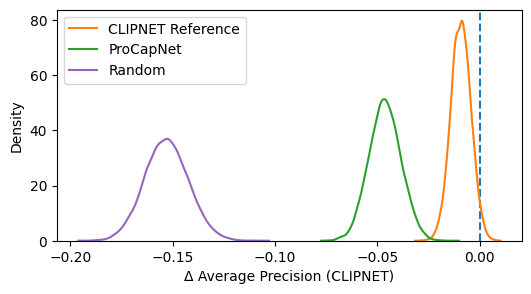

In [50]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 1, 1)
plt.axvline(x=0, color=colors[0], linestyle="--")
sns.kdeplot(bootstraps_delta["clipnet_reference"], label="CLIPNET Reference", color=colors[1])
sns.kdeplot(bootstraps_delta["procapnet"], label="ProCapNet", color=colors[2])
#sns.kdeplot(bootstraps_delta["enformer"], label="Enformer DNase", color=colors[3])
sns.kdeplot(bootstraps_delta["random"], label="Random", color=colors[4])
plt.xlabel("Δ Average Precision (CLIPNET)")
plt.ylabel("Density")
#plt.xticks([-0.25, -0.125, 0.0])
#plt.yticks([0, 40])
plt.legend()
#plt.savefig("img/emVar_average_precision_bootstrap.pdf")

In [28]:
# Compute precision and recall
precision, recall, _ = precision_recall_curve(data.emVar_K562, data.log2fc_clipnet_ensemble ** 2)
precision1, recall1, _ = precision_recall_curve(data.emVar_K562, data.log2fc_clipnet_reference_ensemble ** 2)
precision2, recall2, _ = precision_recall_curve(data.emVar_K562, data.log2fc_procapnet_ensemble ** 2)
rand_precision, rand_recall, _ = precision_recall_curve(data.emVar_K562, np.random.uniform(0, 1, len(data)))

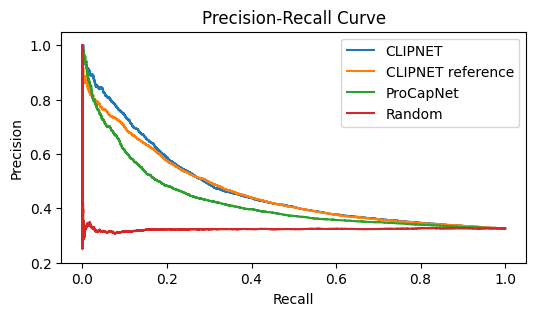

In [29]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 1, 1)

# Plot Precision-Recall Curve
plt.plot(recall, precision)
plt.plot(recall1, precision1)
plt.plot(recall2, precision2)
plt.plot(rand_recall, rand_precision)#, linestyle='--')
plt.ylim(0.2, 1.05)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(["CLIPNET", "CLIPNET reference", "ProCapNet", "Random"])
#plt.savefig("img/emVar_prc.pdf")

In [52]:
l1=[66,
55,
38,
16,
63,
50,
47,
59,
15,
]
l2=[69,
54,
63,
63,
42,
39,
29,
29,
43
]

In [53]:
from scipy.stats import mannwhitneyu, ttest_ind, ttest_rel, wilcoxon, shapiro

In [59]:
ttest_rel(l1, l2)

TtestResult(statistic=-0.2833055106318619, pvalue=0.7841357061970919, df=8)